In [1]:
import numpy as np
import time
from os import getcwd, path
from pathlib import Path
import pandas as pd

from sys import path as sp
sp.append(path.join((Path.cwd()).parent,"scripts"))


# Falsify Data (Pre-live implementation of sensor)

In [2]:
from dataloader_notebook import get_real_testdata, load_to_df, unlink_DStore
from model_utils_training import scale_vals
from filepaths import paths

In [3]:
testfiles=get_real_testdata()
train_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
targetfiles = testfiles
cols = test_cols

# targetfiles = unlink_DStore(targetfiles)
targetfiles[:]

[PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove1_huien_walking_test.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove1_muthu_stand_test (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove2_huien_walking_test.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_nds_glove1_walking_test.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove1_mjing_walking_test.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove2_mjun_walking_test.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove2_muthu_walking_test (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_glove2_nds_standing_test.txt')]

In [22]:
train_classes = ['exit','reload','grenade','shield','idle']

idx = 0
# df = load_to_df(targetfiles[idx:idx+1], cols)
df = load_to_df(targetfiles[idx:idx+4], cols)
df[train_cols[6]] = df[train_cols[6]].str.slice(start=0, stop=-1)
df = df[df['Activity_code'].isin(train_classes)]
df[cols[:6]] = df[cols[:6]].astype('int')
df = df[(df[cols[:6]] <= 255).all(axis=1)]
df = df[(df[cols[:6]] >= 0).all(axis=1)]

df['time']=[i+1 for i in range(df.shape[0])]

df_copy = df.copy()
timestep = 20
data = (df_copy)

testing_class = [data.iloc[i].tolist()[:data.shape[1]-2] for i in range(data.shape[0])]
run_data = testing_class.copy()

# df_copy.head

In [23]:
import matplotlib.pyplot as plt
from visualisers import plot_full_v2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


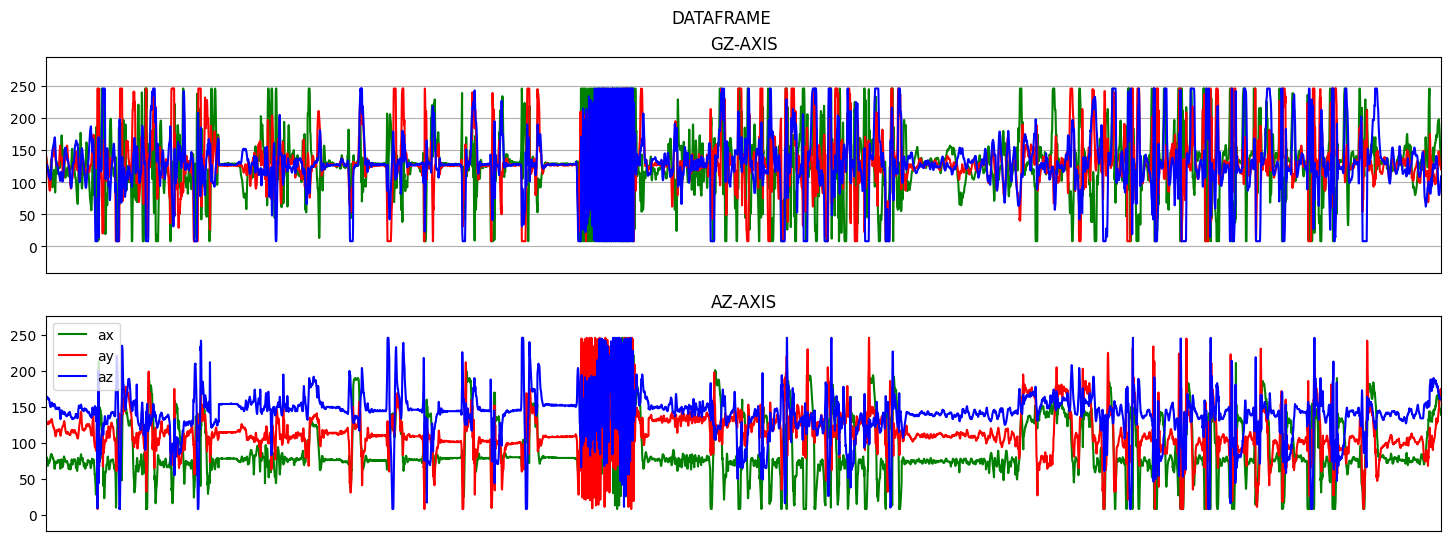

In [24]:
plot_full_v2(df_copy)

# Encode

In [25]:
from model_utils_training import encode, scale_vals, get_frames

In [26]:
df_copy, label = encode(df_copy)

print(label.classes_)
df_copy.head()

['exit' 'grenade' 'idle' 'reload' 'shield']


,ax,ay,az,gx,gy,gz,Activity_code,time,label
0,81,130,164,139,141,128,idle,1,2
1,80,130,165,137,138,128,idle,2,2
2,80,130,164,133,136,128,idle,3,2
3,79,129,164,129,133,128,idle,4,2
4,79,128,163,126,131,127,idle,5,2


In [27]:
data = scale_vals(df_copy)
data = df_copy.copy()
ds_X = data[['ax','ay','az','gx','gy','gz']]
ds_Y = data['label']
scaled_X = pd.DataFrame(data=ds_X, columns=['ax','ay','az','gx','gy','gz'])
scaled_X['Activity_code'] = ds_Y.values
scaled_X

,ax,ay,az,gx,gy,gz,Activity_code
0,0.317647,0.509804,0.643137,0.545098,0.552941,0.501961,2
1,0.313725,0.509804,0.647059,0.537255,0.541176,0.501961,2
2,0.313725,0.509804,0.643137,0.521569,0.533333,0.501961,2
3,0.309804,0.505882,0.643137,0.505882,0.521569,0.501961,2
4,0.309804,0.501961,0.639216,0.494118,0.513725,0.498039,2
...,...,...,...,...,...,...,...
2779,0.572549,0.678431,0.631373,0.584314,0.498039,0.372549,2
2780,0.564706,0.682353,0.627451,0.552941,0.505882,0.380392,2
2781,0.552941,0.686275,0.631373,0.533333,0.482353,0.396078,2
2782,0.545098,0.678431,0.631373,0.517647,0.482353,0.411765,2


In [28]:
import scipy.stats as stats

In [29]:
seconds = 1
Fs = 40
frame_size = int(Fs*seconds/2) # 40 Hz * 1/2 (every half second check) = 20
hop_size = int(Fs/8) # hop every 5 steps

In [30]:
x, y = get_frames(scaled_X, frame_size, hop_size, labelled=True)
x.shape, y.shape

/Users/anderson/Desktop/github/capstoneml/scripts/model_utils_training.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(filt_df['Activity_code'][i: i + frame_size])[0][0]


((1422, 20, 6), (1422,))

# Load Model

In [31]:
import tensorflow as tf

In [32]:
model_name = 'cnn-mix-stride20'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model = tf.keras.models.load_model(MODEL_DIR)
# model.summary()

# FPGA Initialisation

outputs: <br>
0: Grenade
1: Reload
2: Exit
3: Shield
4: IDLE
5: IGNORE

In [33]:
from start_detector_tensor import Detector

In [34]:
fpga_detector = Detector(model_name)

In [35]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# MODEL VS ACTUAL

In [84]:
# fpga_detector = Detector('cnn-stand-2idle-1k')
out = []
for d in run_data[:]:
    o = fpga_detector.eval_data(d,3,0.8,0.040,4)
    out.append(o)

[2, 3, 4, 4, 4, 3, 3]
[2, 1, 1, 1, 1, 1, 1]
[2, 3, 3, 3, 4, 4, 4, 4]
[2, 3, 1, 3, 3, 3]
[2, 1, 1, 1, 1, 1, 1]
[2, 4, 4, 4, 4, 4, 4, 4]
[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 4, 3, 3, 3, 3]
[2, 4, 4, 4, 4, 4]
[2, 3, 3, 3, 3]
[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 4, 4, 4, 4, 4]
[2, 3, 3, 3, 3, 3, 3, 3]
[2, 3, 3, 3, 3, 3, 3]
[2, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 4, 4, 1, 1, 1, 1, 1, 1]
[2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 4, 4, 4, 4, 4]
[2, 3, 1, 1, 1, 1, 1]
[2, 1, 1, 1, 1, 0]
[2, 4, 4, 4, 4, 4, 4]
[2, 3, 1, 1, 1, 1, 1]
[2, 3, 3, 1, 0, 3, 3, 3]
[2, 3, 3, 1, 1, 4, 4, 4]
[2, 3, 4, 0, 1, 1, 1, 1, 1, 3]
[2, 4, 4, 4, 4, 4, 4]
[2, 3, 3, 3, 3, 3, 3, 3]
[2, 1, 1, 1, 1]
[2, 3, 3, 1, 3, 3, 3]
[2, 4, 4, 4, 4, 4]


In [87]:
from tensorflow import string


y_pred = model.predict(x)
classes_y = np.argmax(y_pred,axis=1)
chances = np.array([y_pred[i][np.argmax(y_pred[i])] for i in range(y_pred.shape[0])])

keep=[]
offsetted = 2
for i in range(0,len(out)):
    if i%5==offsetted:
        keep.append(i)
ignore = 0
track=0
for i in keep:
    if ignore < 4:
        ignore += 1
    elif out[i]==2:
        print("-", end=" ")
    else:
        track+=1
        tracked = "[ {} ]".format(track)
        for q in range(len(tracked)+1):
            sys.stdout.write('\b')
            sys.stdout.flush()
        print(tracked, out[i], end=" ")

print("\n\nVERSUS REAL Actual\n")

for rv in y:
    if rv==2:
        print("-", end=" ")
    else:
        print(rv, end=" ")
    
print("\n\nVERSUS\n")

for i in range(chances.shape[0]):
    if chances[i] < 0.75:
        print("-", end=" ")
    elif classes_y[i] == 2:
        print("-", end=" ")
    else:
        print(classes_y[i], end=" ")


45/45 [==============================] - 0s 762us/step
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - [ 1 ] 3 - - - - - - - - - - - - - - - - - - - - [ 2 ] 1 - - - - - - - - - - - - - - - - - - - - - - - - - [ 3 ] 4 - - - - - - - - - - - - - - - - - - - - - - - [ 4 ] 3 - - - - - - - - - - - - - - - - - - - - - [ 5 ] 1 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - [ 6 ] 4 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - [ 7 ] 1 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - [ 8 ] 3 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - [ 9 ] 4 - - - - - - - - - - - - - - - - - - - - - - - - - -[ 10 ] 3 - - - - - - - - - - - - - -

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

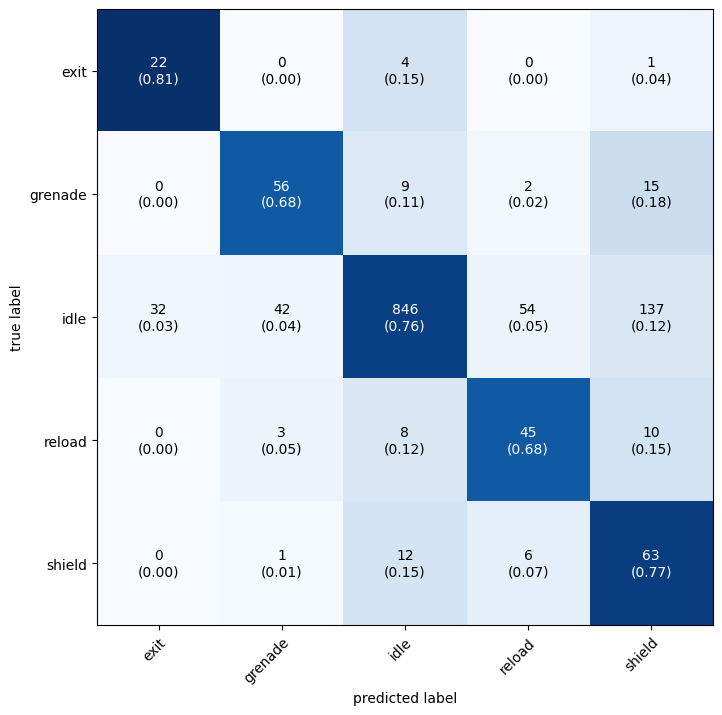

In [81]:
real_y = y
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

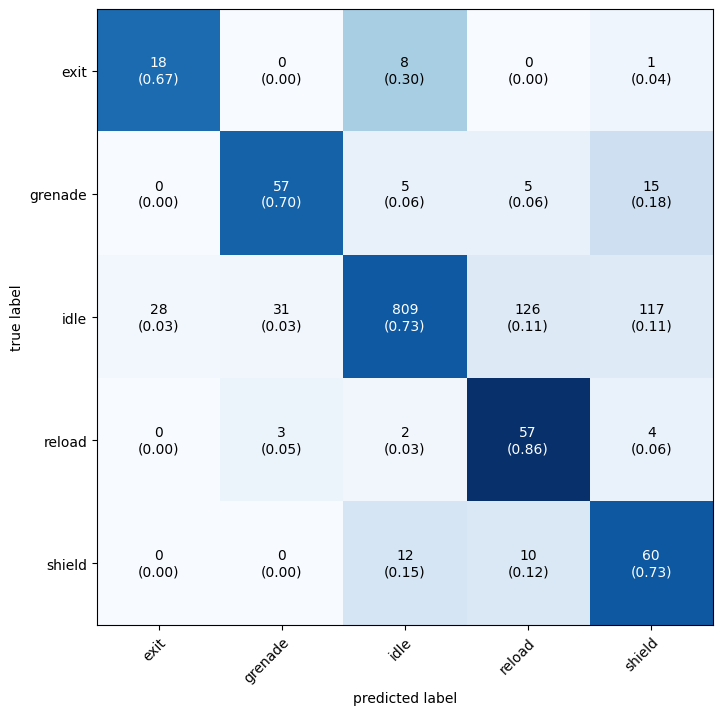

In [89]:
real_y = y
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

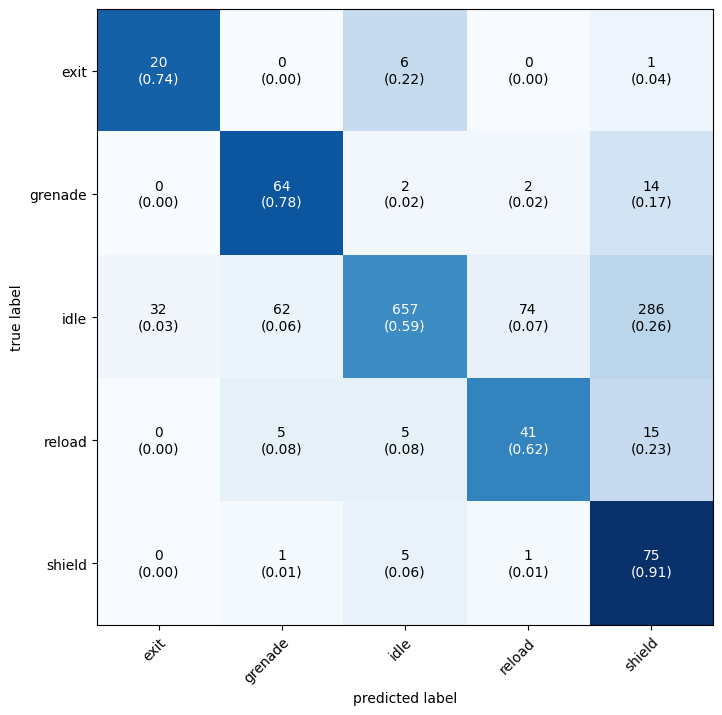

In [85]:
real_y = y
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


In [30]:
file = open(targetfiles[0])
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[6].split(';')[0]
        last = last.strip()
        if last == '':
            break
        temp = [line[0], line[1], line[2], line[3], line[4], line[5], last]
        print(temp)

        if last == 'exit':
            print(i)
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

['106', '150', '173', '132', '124', '127', 'idle']
['105', '150', '173', '133', '126', '127', 'idle']
['105', '151', '173', '132', '127', '126', 'idle']
['105', '152', '173', '130', '127', '125', 'idle']
['105', '152', '174', '130', '126', '125', 'idle']
['105', '152', '173', '129', '126', '124', 'idle']
['106', '151', '173', '129', '127', '124', 'idle']
['105', '152', '174', '130', '128', '124', 'idle']
['105', '153', '173', '128', '128', '123', 'idle']
['105', '152', '174', '128', '127', '123', 'idle']
['105', '153', '175', '130', '127', '124', 'idle']
['104', '154', '175', '128', '128', '124', 'idle']
['102', '155', '176', '128', '127', '123', 'idle']
['102', '157', '175', '127', '123', '125', 'idle']
['103', '157', '175', '126', '121', '128', 'idle']
['104', '157', '175', '126', '121', '129', 'idle']
['104', '157', '175', '125', '122', '130', 'idle']
['104', '156', '176', '125', '122', '132', 'idle']
['104', '156', '175', '127', '123', '134', 'idle']
['105', '156', '174', '126', '1